# Clustering

see also https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB15-CXII-clustering.html

## Clustering with scikit-learn

The goal of this notebook is to familiarize the reader with how to implement clustering algorithms with the scikit-learn package. After this notebook, the reader should understand how to implement common clustering algorithms using Scikit learn and use Principal Component Analysis (PCA) to visualize clustering in high-dimensions. Moreover our goal is to convey to the reader some of the intuitions concerning clustering validation, i.e. determining which clustering assignment is best.

## Methods

We will look at some clustering methods (K-means, DBSCAN, hierarchical clustering) and use artificial datasets. 
The reader is encouraged to use the [scikit-learn library](https://scikit-learn.org/stable/auto_examples/index.html)

## Generate artificial dataset and then test clustering methods

------> Example with 10 true cluster centers <-------


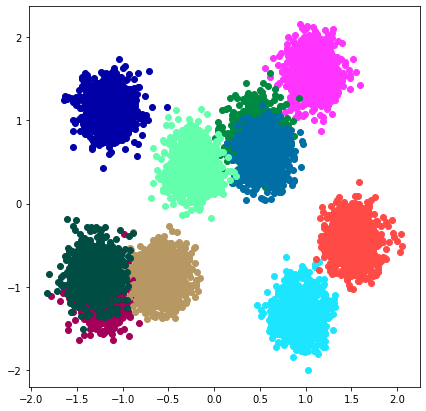

In [3]:
from sklearn.datasets import make_blobs
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler 
import numpy as np
from matplotlib import pyplot as plt 

n_true_center = 10 #10

np.random.seed(13) #13

print("------> Example with %i true cluster centers <-------"%n_true_center)

X, y = make_blobs(n_samples= 10000, n_features=2, centers =n_true_center) # Generating random gaussian mixture

#print(X)

X = StandardScaler().fit_transform(X)

#print(X)

#cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]


def plot_clustering(X,y):
    cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

    plt.figure(figsize=(7,7))
    for i, yu in enumerate(np.unique(y)):

        pos = (y==yu) #create a mask for each cluster 
     
        plt.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)])
    plt.show()

    
plot_clustering(X,y)


ytrue = y
#print(y)

#print(X)
#print(X[:,1])
    

## Clustering accuracy and clustering algorithm parameters 

### Exercises: 

1. How would you define what a good cluster or a good clustering assignment is?
2. Given that you have access to ground truth labels, can you define a metric to measure clustering accuracy?
3. Can you devise a metric that does not use ground truth labels? Is that metric monotonic in the number of clusters?
4. Can you think of a way of leveraging supervised learning to construct a measure of clustering accuracy (without access to ground truth labels)?

One way to quantitatively measure the performance of a clustering method is to compare the predicted labels to the ground-truth labels (given that those are available). Here we will use the **normalized mutual information** (see https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html for more discussion on the subject and other possible metrics) to perform such comparison. As we will see, when doing clustering, there is usually no free lunch: if one chooses the wrong set of parameters (which can be quite sensitive), the clustering algorithm will likely fail or return a trivial answer (for instance all points assigned to the same cluster).

In [4]:
from collections import OrderedDict

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    
    #print(clustering)
    
    for ye in yu:
        #print(ye)
        #print(np.where(y == ye))
        clustering[ye] = np.where(y == ye)[0]  #return the [indices] where condition is true
    return clustering
# OrderedDict dict subclass that remembers the order entries were added
# https://www.geeksforgeeks.org/ordereddict-in-python/

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h


# Normalized mutual information function
# Note that this deals with the label permutation problem
# Normalized Mutual Information (NMI) is a normalization of the Mutual Information (MI) score 
# to scale the results between 0 (no mutual information) and 1 (perfect correlation).
# This metric is furthermore symmetric: switching label_true with label_pred will return the same score value. 
# This can be useful to measure the agreement of two independent label assignments strategies on the same dataset when the real ground truth is not known.

def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc]))) 
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)  # entropy of cluster label 
    Hw = entropy(w,n_sample)  # entropy of class label

    return 2*Iwc/(Hc+Hw)       
    # it's possible to demonstrate that I(x,y) is the expectation of Kullback-Leibler 
    # divergence of p(x) from the conditional distribution p(x|y) = p(y*x)/(p(x)*p(y))
    # the more p(x) and p(x|y) are different, the larger is the gain in information  
    # The above is a measure of a symmetric uncertainty which represents an harmonic mean

## K-Means 


K-means is a simple clustering methods based on minimizing the inertia of clusters. 


<!--
![SegmentLocal](images/k-means_anim.gif "segment")
![SegmentLocal](images/k-means_algo.png "segment")
-->

<img src="images/k-means_anim.gif" align ="left" width="45%"/>
<img src="images/k-means_algo.png" align ="left" width="70%"/>


</br>

One tries to find K cluster centers with points tightly distributed around them. K-means has the advantage of being scalable to very large datasets. One of the two main problems with K-means is that

1. K has to be fixed by the user (so K-means is semi-supervised)
2. K-means can only deal with "convex" clusters

We can measure the performance of K-means by thinking about the *distortion*---the square distance of each point from the centroid defining the cluster. This is the objective function that K-means tries to optimize.

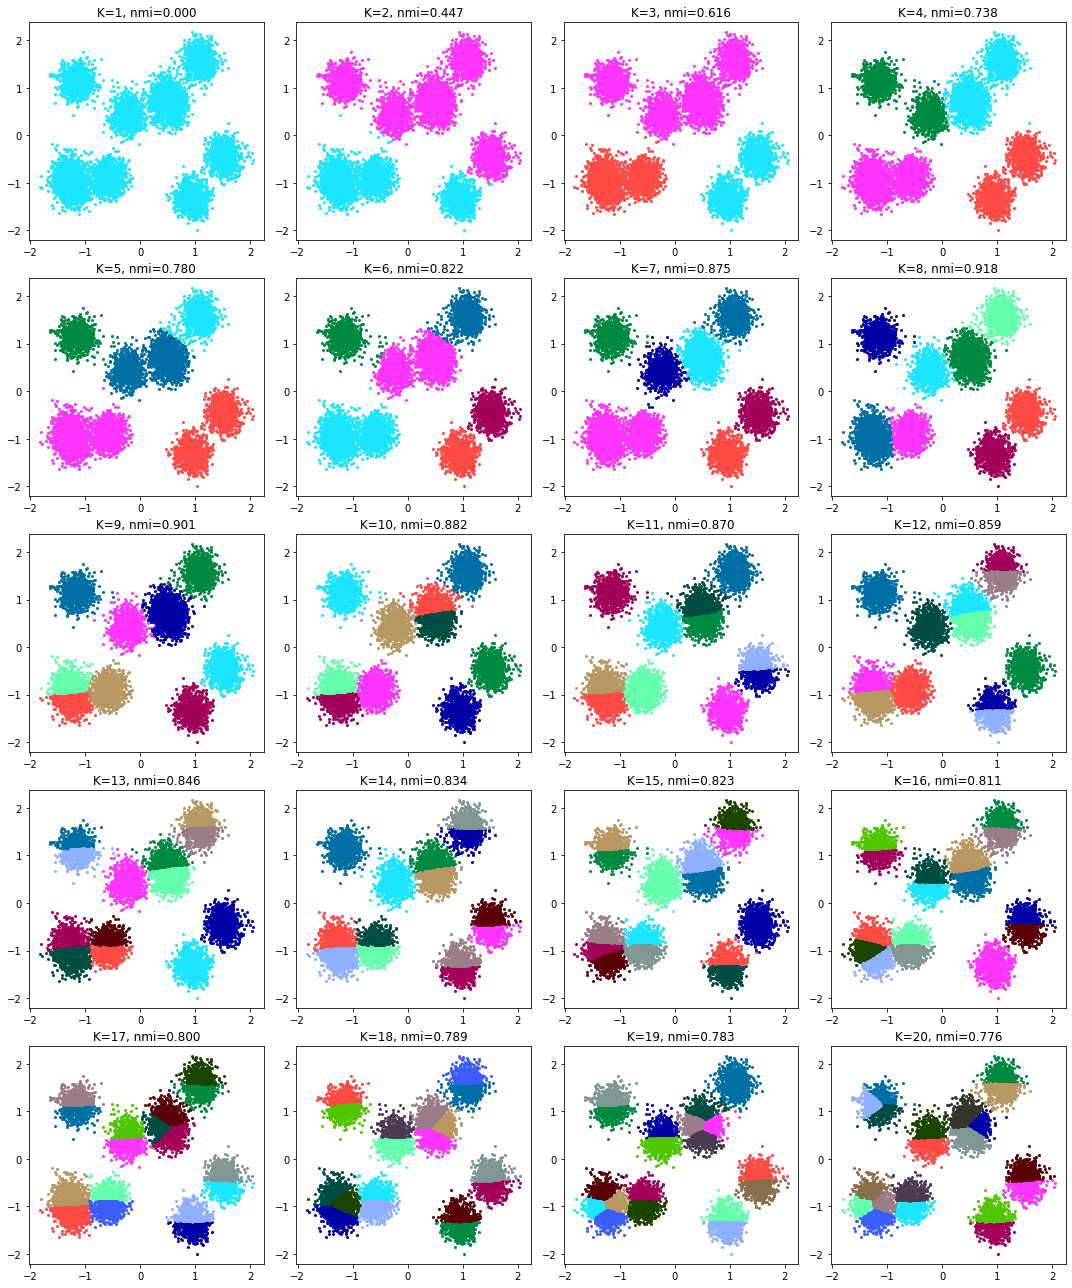

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def plotting_ax(X, y, ax):
    cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6",\
                "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", \
                "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", \
                "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", \
                "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", \
                "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

    # plotting function
    for i, yu in enumerate(np.unique(y)):
        #print(i, yu)
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

   

K_range = np.arange(20).reshape(5,4)
fig, ax = plt.subplots(K_range.shape[0], K_range.shape[1], figsize=(15,18))      

distortion = []
nmi_fun = []
for i in range(K_range.shape[0]):
    for j in range(K_range.shape[1]):
        model = KMeans(n_clusters=K_range[i,j]+1)
        model.fit(X)
        y = model.labels_
        plotting_ax(X, y, ax[i,j])
        nmi=NMI(y, ytrue)
        ax[i,j].set_title('K=%i, nmi=%.3f'%(K_range[i,j]+1,nmi))
        distortion.append(model.inertia_)
        nmi_fun.append(nmi)
plt.tight_layout(h_pad=0.5) #padding between figure edge and edges of subplots 
plt.show()


We see that  K-Means does a rather good job at dealing with Gaussian mixtures of equal variances. The normalized mutual information is maximized around K=15. Notice that one usually does not have access to ground-truth labels. Many simple measures of clustering can be devised to measure clustering accuracy (for instance the distortion, see above). These however tend to be monotonic in the number of clusters. Maximizing/minimizing such metrics will lead to trivial solutions. Instead one usually tries to find a point of inflexion (or kink) in the metric, which signifies a major change in the clustering algorithm and can be sometimes associated with the regime of good solutions.


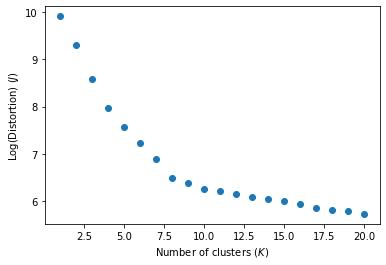

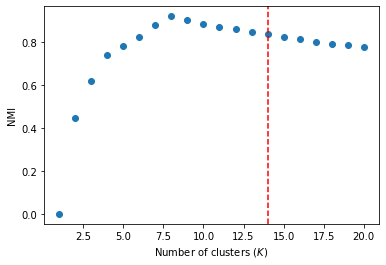

In [6]:
plt.scatter(K_range.flatten()+1, np.log(distortion))
plt.xlabel('Number of clusters ($K$)')
plt.ylabel('Log(Distortion) ($J$)')
plt.show()


plt.scatter(K_range.flatten()+1, (nmi_fun))
plt.axvline(x=14, color='r', linestyle='--')
plt.xlabel('Number of clusters ($K$)')
plt.ylabel('NMI')
plt.show()


## Density based clustering 


https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
https://github.com/scikit-learn-contrib/hdbscan

(k=6)



<!-- ![SegmentLocal](mutual_reachability.png | width=200) -->
<img src="images/mutual_reachability.png" width="50%"/>
<img src="images/hdbscan_tree.png" width="50%"/>

Density based clustering --- (see also HDBSCAN in the following)

**Mutual Reachability**: </br>

$d_{{mreach-k}} (a,b) = max\{core_{k}(a), core_{k}(b), d(a,b) \}$




Expand: Minimum spanning tree
https://en.wikipedia.org/wiki/Prim%27s_algorithm


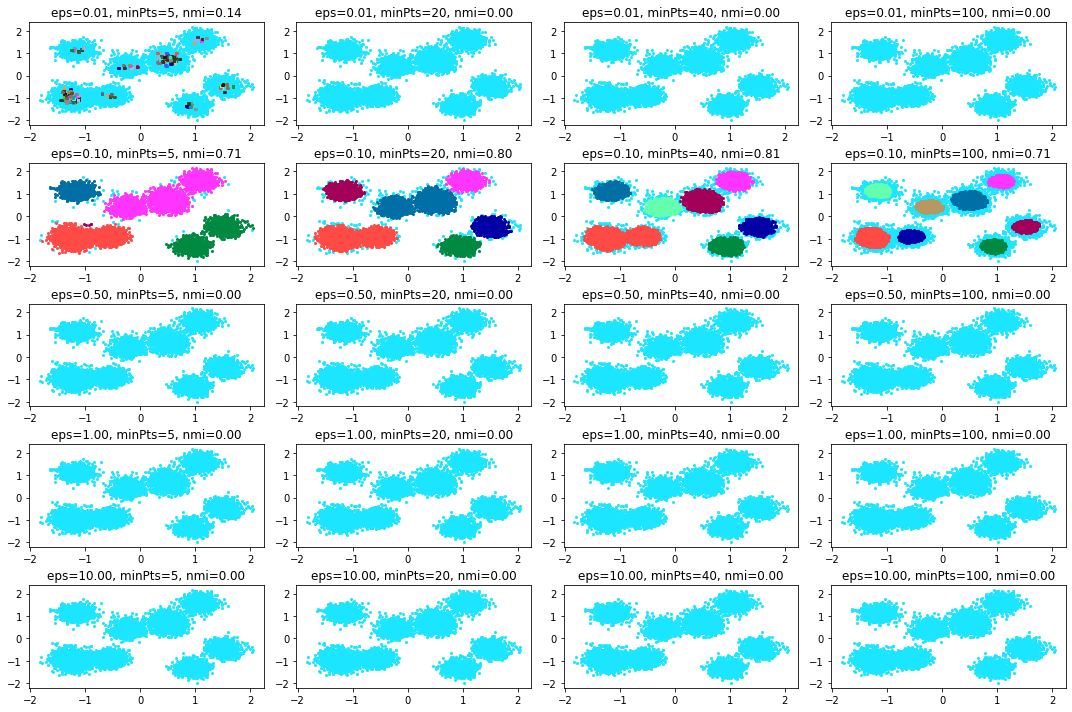

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens

#hyperparameters of DBSCAN 
eps_range = [0.01,0.1,0.5,1.0,10.]
min_sample_range = [5,20,40,100]

fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        plotting_ax(X,y,ax[i,j])
        nmi=NMI(y, ytrue)
        ax[i,j].set_title('eps={:.2f}, minPts={:d}, nmi={:.2f}'.format(eps,min_samples,nmi))
plt.tight_layout(h_pad=0.5)
plt.show()



## HDBSCAN

https://github.com/scikit-learn-contrib/hdbscan

https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

https://towardsdatascience.com/a-gentle-introduction-to-hdbscan-and-density-based-clustering-5fd79329c1e8

https://pberba.github.io/stats/2020/01/17/hdbscan/

HDBSCAN is basically a DBSCAN implementation for varying epsilon values and therefore only needs the minimum cluster size as single input parameter. Unlike DBSCAN, this allows to it find clusters of variable densities without having to choose a suitable distance threshold first. 


In **soft clustering**, instead of putting each data point into a separate cluster (hard clustering), a probability or likelihood of that data point to be in those clusters is assigned. The hdbscan library implements soft clustering, where each data point is assigned a cluster membership score ranging from 0.0 to 1.0. 
A score of 0.0 represents a sample that is not in the cluster at all (all noise points will get this score) while a score of 1.0 represents a sample that is at the heart of the cluster (note that this is not the spatial centroid notion of core). 

Notice you can change the metric. Supported metrics are listed here: https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html

Density based clustering algorithms are also utilized for outlier detection:
https://hdbscan.readthedocs.io/en/latest/outlier_detection.html </br> https://en.wikipedia.org/wiki/Local_outlier_factor



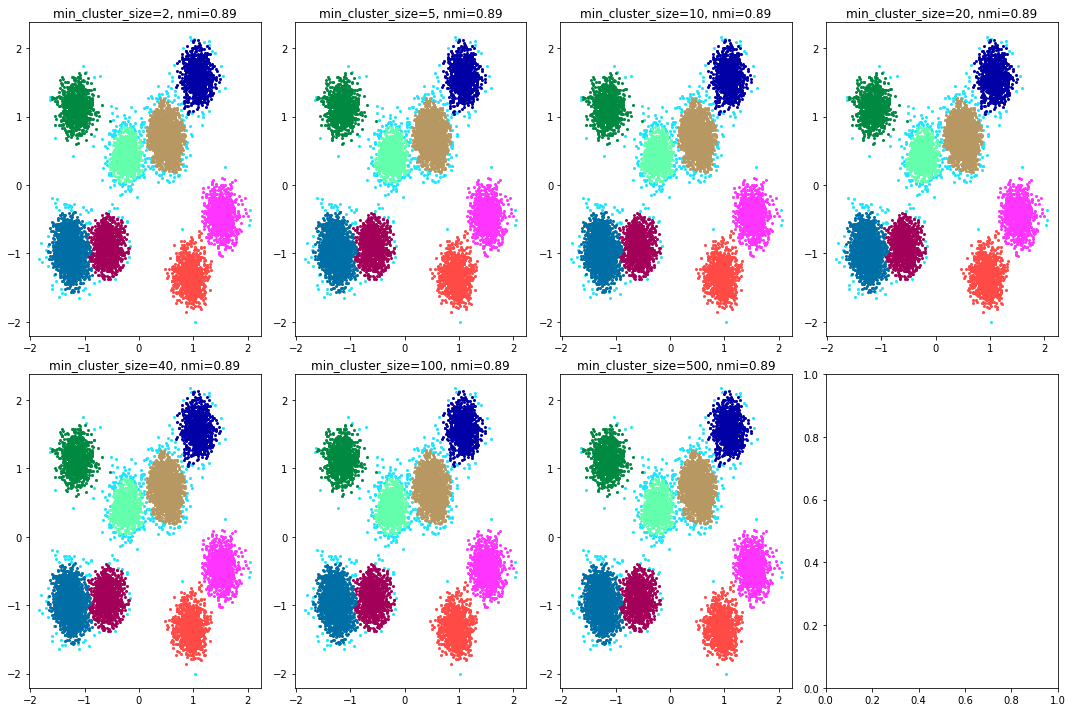

"\nfig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))\n\n\nfor i, eps in enumerate(min_cluster_size):\n    model = DBSCAN(eps=eps, min_samples=min_samples)\n    model.fit(X)\n    y = model.labels_\n    plotting_ax(X,y,ax[i,j])\n    nmi=NMI(y, ytrue)\n    ax[i,j].set_title('eps={:.2f}, minPts={:d}, nmi={:.2f}'.format(eps,min_samples,nmi))\nplt.tight_layout(h_pad=0.5)\nplt.show()\n"

In [8]:
import hdbscan

min_cluster_size = [2,5,10,20,40,100,500]

columns = 4
rows = len(min_cluster_size)//columns + 1


subplots = ([0]*(rows*columns))
subplots = np.array(subplots)

subplots[: len(min_cluster_size)] = min_cluster_size[:]

subplots = subplots.reshape(rows,columns)

fig, ax = plt.subplots(rows,columns,figsize=(15,10))


for i in (np.arange(rows)):
    for j in (np.arange(columns)):
        #
        if(subplots[i,j]==0):
            continue
        
        #print("\n\n...", i,j, subplots[i,j],"...\n\n")
        
        min_clu_size = int(subplots[i,j])
        model = hdbscan.HDBSCAN(min_cluster_size=min_clu_size, min_samples=20, metric='manhattan')
        model.fit(X)
        y = model.labels_
        probabilities = model.probabilities_
        outlier_scores = model.outlier_scores_ 
        #print(np.shape(probabilities), np.shape(outlier_scores))
        #print(probabilities)
        #print(outlier_scores)
        plotting_ax(X,y,ax[i,j])
        nmi=NMI(y, ytrue)
        ax[i,j].set_title('min_cluster_size={:d}, nmi={:.2f}'.format(min_clu_size,nmi))
plt.tight_layout(h_pad=0.5)
plt.show()       




"""
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))


for i, eps in enumerate(min_cluster_size):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(X)
    y = model.labels_
    plotting_ax(X,y,ax[i,j])
    nmi=NMI(y, ytrue)
    ax[i,j].set_title('eps={:.2f}, minPts={:d}, nmi={:.2f}'.format(eps,min_samples,nmi))
plt.tight_layout(h_pad=0.5)
plt.show()
"""

## Utilization of probability scores 

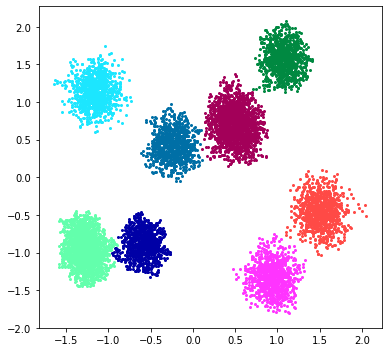

(9580, 2)


<AxesSubplot:ylabel='$\\lambda$ value'>

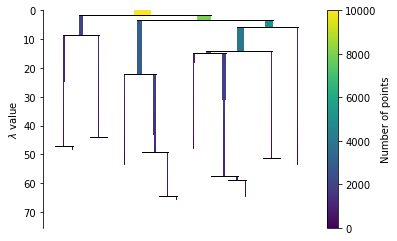

In [9]:
# filtering events that do not pass probability cuts 

min_clu_size = 100 

min_samples = 2

model = hdbscan.HDBSCAN(min_cluster_size=min_clu_size, min_samples=min_samples, metric='manhattan')
model.fit(X)

y = model.labels_
probabilities = model.probabilities_
outlier_scores = model.outlier_scores_  #https://en.wikipedia.org/wiki/Local_outlier_factor

# choose your cuts
mask_prob = probabilities>0.10 
mask_outlier = outlier_scores <0.90




mask_all = np.logical_and(mask_prob,mask_outlier)

Xm   = X[mask_all]
ym   = y[mask_all]
ytrm = ytrue[mask_all]


fig, ax = plt.subplots(1, 1, figsize=(5.5,5))      

plotting_ax(Xm,ym,ax)

plt.tight_layout(h_pad=0.5)
plt.show()   

print(np.shape(Xm))

model.condensed_tree_.plot()


# https://hdbscan.readthedocs.io/en/latest/advanced_hdbscan.html

## Representation of multi-dimensional clustering (PCA vs t-SNE)

In [10]:
n_true_center = 10
nsamples = 10000
np.random.seed(12) #13

# this can be, e.g., x,y,t hits
X, y = make_blobs(n_samples= nsamples, n_features=4, centers =n_true_center)  

X = StandardScaler().fit_transform(X)


model = hdbscan.HDBSCAN(min_cluster_size=min_clu_size, min_samples=min_samples, metric='manhattan')
model.fit(X)


ypred = model.labels_
probabilities = model.probabilities_
outlier_scores = model.outlier_scores_ 



In [11]:
from sklearn.decomposition import PCA

idx = np.arange(len(X))
# if you want to downsample
#rand = np.random.choice(idx, size=1000, replace=False) #False: elements not repeated
#Xdownsample = X[rand]   
# otherwise 
Xdownsample = X

modelPCA = PCA(n_components=2)
XPCA = modelPCA.fit_transform(Xdownsample)

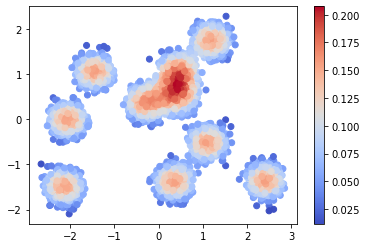

In [12]:
from scipy.stats import gaussian_kde

# Principal axes in feature space, representing the directions of maximum variance in the data
component1 = modelPCA.components_[0]
component2 = modelPCA.components_[1]

vx,vy = XPCA[:,0],XPCA[:,1]
vxvy = np.vstack([vx,vy])
z = gaussian_kde(vxvy)(vxvy)
plt.scatter(vx,vy,c=z,cmap="coolwarm") 
cb = plt.colorbar()



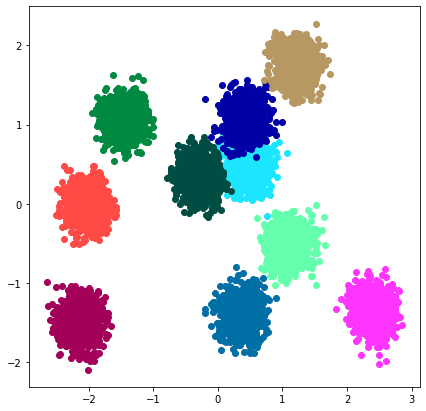

In [13]:
#---------- show plot with true cluster labels ---------# 

#fig, ax = plt.subplots(1, 1, figsize=(5.5,5))      

#plotting_ax(XPCA,y,ax)
#plt.tight_layout(h_pad=0.5)
#plt.show()  

plot_clustering(XPCA,y)



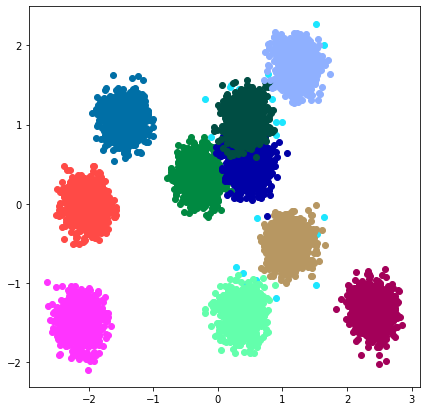

In [14]:
#---------- show plot with predicted cluster labels ---------# 

#fig, ax = plt.subplots(1, 1, figsize=(5.5,5))      
#plotting_ax(XPCA,ypred,ax)
#plt.tight_layout(h_pad=0.5)
#plt.show()  


plot_clustering(XPCA,ypred)


## Adding noise and check how hdbscan is effective in identifying noise

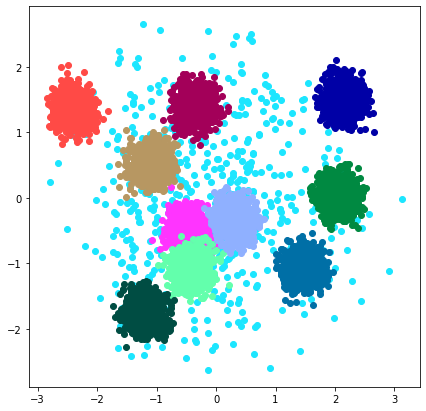

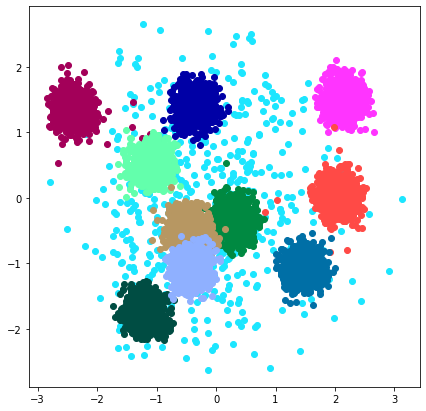

In [15]:
noise_x = np.random.uniform(-2.,2.,(500,4))
noise_y = np.array([-999]*500)

#print(np.shape(noise_x), np.shape(X), np.shape(noise_y))

X_noise = np.vstack([X,noise_x])


ty = y.reshape(len(y),1)
tny = noise_y.reshape(len(noise_y),1)

y_noise = np.vstack([ty,tny])

y_noise = y_noise.reshape(len(y_noise),)


model = hdbscan.HDBSCAN(min_cluster_size=min_clu_size, min_samples=min_samples, metric='manhattan')
model.fit(X_noise)


ypred = model.labels_
probabilities = model.probabilities_
outlier_scores = model.outlier_scores_ 



modelPCA = PCA(n_components=2)
XPCA = modelPCA.fit_transform(X_noise)


plot_clustering(XPCA,y_noise)
plot_clustering(XPCA,ypred)

#print(np.shape(y_noise))
#print(np.shape(ypred))

### filter out noise with probability cuts 

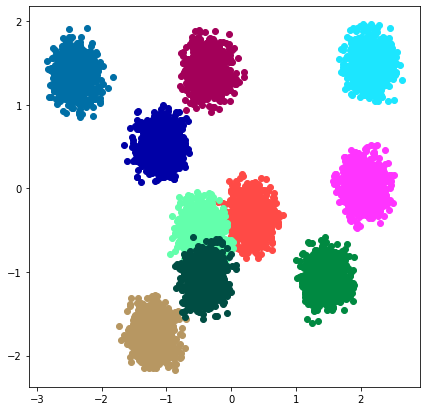

In [16]:
# choose your cuts
mask_prob = probabilities>=0.30 
mask_outlier = outlier_scores <=0.80

mask_all = np.logical_and(mask_prob,mask_outlier)

Xmpca   = XPCA[mask_all]
ym   = y_noise[mask_all]
ytrm = ypred[mask_all]

plot_clustering(Xmpca,ytrm)

## Dimensionality reduction with t-SNE

One of the most major differences between PCA and t-SNE is that it preserves only local similarities.

In [17]:
from sklearn.manifold import TSNE 

model = TSNE(n_components=2, random_state=0) 
XTSNE = model.fit_transform(X_noise)

/Users/cfanelli/Desktop/repositories/env_ml4hep/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/cfanelli/Desktop/repositories/env_ml4hep/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


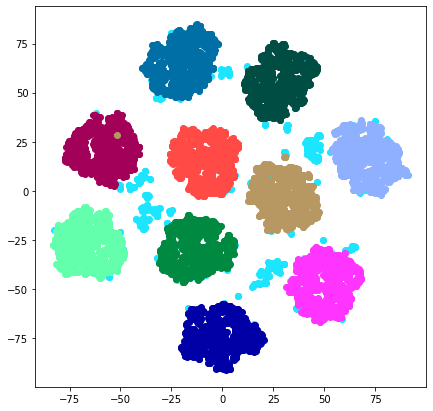

In [18]:
plot_clustering(XTSNE,y_noise) 

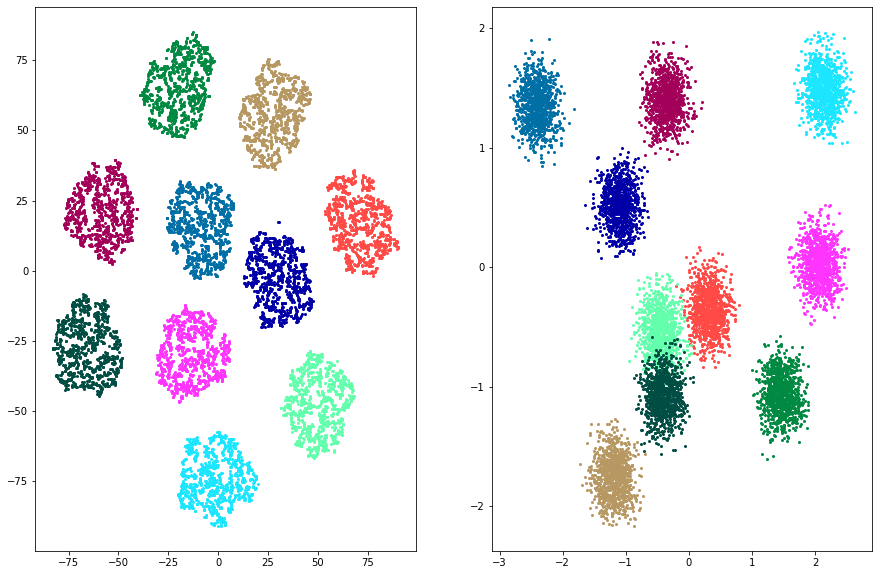

In [19]:
Xmtsne   = XTSNE[mask_all]


fig, ax = plt.subplots(1,2,figsize=(15,10))

plotting_ax(Xmtsne,ytrm,ax[0]) 
plotting_ax(Xmpca,ytrm,ax[1]) 


#plot_clustering(Xm,ytrm)

